In [1]:
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from scipy.stats import norm,poisson
plt.style.use("figures.mplstyle")
light_generators = ["EPOSLHC","DPMJET","SIBYLL","QGSJET","PYTHIA8"]
charm_generators = ["BKSS","BKRS","SIBYLL","BDGJKR","MS"]
colors = {("EPOSLHC","BKSS"):"mediumorchid",
          ("DPMJET","BKRS"):"deepskyblue",
          ("SIBYLL","SIBYLL"):"darkseagreen",
          ("QGSJET","BDGJKR"):"goldenrod",
          ("PYTHIA8","MS"):"indianred"
         }

In [2]:
forward_flux_files = {
    "LHC13":{
        "light":["DPMJET", "EPOSLHC", "PYTHIA8", "QGSJET", "SIBYLL"],
        "charm":["BDGJKR", "BKRS", "BKSS", "MS", "SIBYLL"]
    },
    "Large":{
        "light":["EPOSLHC"],
        "charm":["BKRS"]
    },
    "Run3":{
        "light":["EPOSLHC"],
        "charm":["POWHEG+P8monash"]
    },
    "VLarge":{
        "light":["EPOSLHC","SIBYLL"],
        "charm":["BKRS"]
    }
}
primaries = [12,-12,
             14,-14,
             16,-16
            ]
datasets={"SINE_CMS_West":["CC"],
           "UNDINE_CMS_East":["CC","NC"]}

num_UNDINE = 5

data = {}
for detector,xs_models in datasets.items():
    for xs_model in xs_models:
        for prefix,parent_dict in forward_flux_files.items():
            if prefix!="LHC13": continue
            for parent,generators in parent_dict.items():
                for generator in generators:
                    for primary in primaries:
                        if "SINE" in detector and abs(primary)!=14: continue
                        if parent=="light" and abs(primary)==16: continue
                        key = tuple((detector,xs_model,prefix,generator,parent,primary))
                        print(key)
                        if xs_model=="CC": 
                            siren_output_file = "Data/SIREN/Output/%s/%s_%s_%s_%s"%(detector,prefix,generator,parent,primary)
                            compressed_output_file = "Data/SIREN/Output/%s/compressed/%s_%s_%s_%s"%(detector,prefix,generator,parent,primary)
                        else: 
                            siren_output_file = "Data/SIREN/Output/%s/%s_%s_%s_%s_%s"%(detector,prefix,generator,parent,primary,xs_model)
                            compressed_output_file = "Data/SIREN/Output/%s/compressed/%s_%s_%s_%s_%s"%(detector,prefix,generator,parent,primary,xs_model)
                        #try:
                        data[key] = ak.from_parquet(compressed_output_file+".parquet")
                        #if "SINE" in detector: 
                        #    tmp_data = tmp_data[tmp_data.hit_mask_muon_survival]
                        #elif "UNDINE" in detector: 
                        #    tmp_data = tmp_data[np.array(tmp_data.in_fiducial)[:,-1]]
                        #ak.to_parquet(tmp_data,compressed_output_file+".parquet")
                        # except:
                        #     print("Couldn't open %s"%siren_output_file)
                

('SINE_CMS_West', 'CC', 'LHC13', 'DPMJET', 'light', 14)
('SINE_CMS_West', 'CC', 'LHC13', 'DPMJET', 'light', -14)
('SINE_CMS_West', 'CC', 'LHC13', 'EPOSLHC', 'light', 14)
('SINE_CMS_West', 'CC', 'LHC13', 'EPOSLHC', 'light', -14)
('SINE_CMS_West', 'CC', 'LHC13', 'PYTHIA8', 'light', 14)
('SINE_CMS_West', 'CC', 'LHC13', 'PYTHIA8', 'light', -14)
('SINE_CMS_West', 'CC', 'LHC13', 'QGSJET', 'light', 14)
('SINE_CMS_West', 'CC', 'LHC13', 'QGSJET', 'light', -14)
('SINE_CMS_West', 'CC', 'LHC13', 'SIBYLL', 'light', 14)
('SINE_CMS_West', 'CC', 'LHC13', 'SIBYLL', 'light', -14)
('SINE_CMS_West', 'CC', 'LHC13', 'BDGJKR', 'charm', 14)
('SINE_CMS_West', 'CC', 'LHC13', 'BDGJKR', 'charm', -14)
('SINE_CMS_West', 'CC', 'LHC13', 'BKRS', 'charm', 14)
('SINE_CMS_West', 'CC', 'LHC13', 'BKRS', 'charm', -14)
('SINE_CMS_West', 'CC', 'LHC13', 'BKSS', 'charm', 14)
('SINE_CMS_West', 'CC', 'LHC13', 'BKSS', 'charm', -14)
('SINE_CMS_West', 'CC', 'LHC13', 'MS', 'charm', 14)
('SINE_CMS_West', 'CC', 'LHC13', 'MS', 'charm', 

# paper figures from SIREN

In [16]:
def weighted_quantile(values, quantiles, sample_weight=None, 
                      values_sorted=False, old_style=False):
    """ Very close to numpy.percentile, but supports weights.
    NOTE: quantiles should be in [0, 1]!
    :param values: numpy.array with data
    :param quantiles: array-like with many quantiles needed
    :param sample_weight: array-like of the same length as `array`
    :param values_sorted: bool, if True, then will avoid sorting of
        initial array
    :param old_style: if True, will correct output to be consistent
        with numpy.percentile.
    :return: numpy.array with computed quantiles.
    """
    values = np.array(values)
    quantiles = np.array(quantiles)
    if sample_weight is None:
        sample_weight = np.ones(len(values))
    sample_weight = np.array(sample_weight)
    assert np.all(quantiles >= 0) and np.all(quantiles <= 1), \
        'quantiles should be in [0, 1]'

    if not values_sorted:
        sorter = np.argsort(values)
        values = values[sorter]
        sample_weight = sample_weight[sorter]

    weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
    if old_style:
        # To be convenient with numpy.percentile
        weighted_quantiles -= weighted_quantiles[0]
        weighted_quantiles /= weighted_quantiles[-1]
    else:
        weighted_quantiles /= np.sum(sample_weight)
    return np.interp(quantiles, weighted_quantiles, values)

EPOSLHC BKSS
DPMJET BKRS
SIBYLL SIBYLL
QGSJET BDGJKR
PYTHIA8 MS
EPOSLHC BKSS
DPMJET BKRS
SIBYLL SIBYLL
QGSJET BDGJKR
PYTHIA8 MS
EPOSLHC BKSS
DPMJET BKRS
SIBYLL SIBYLL
QGSJET BDGJKR
PYTHIA8 MS


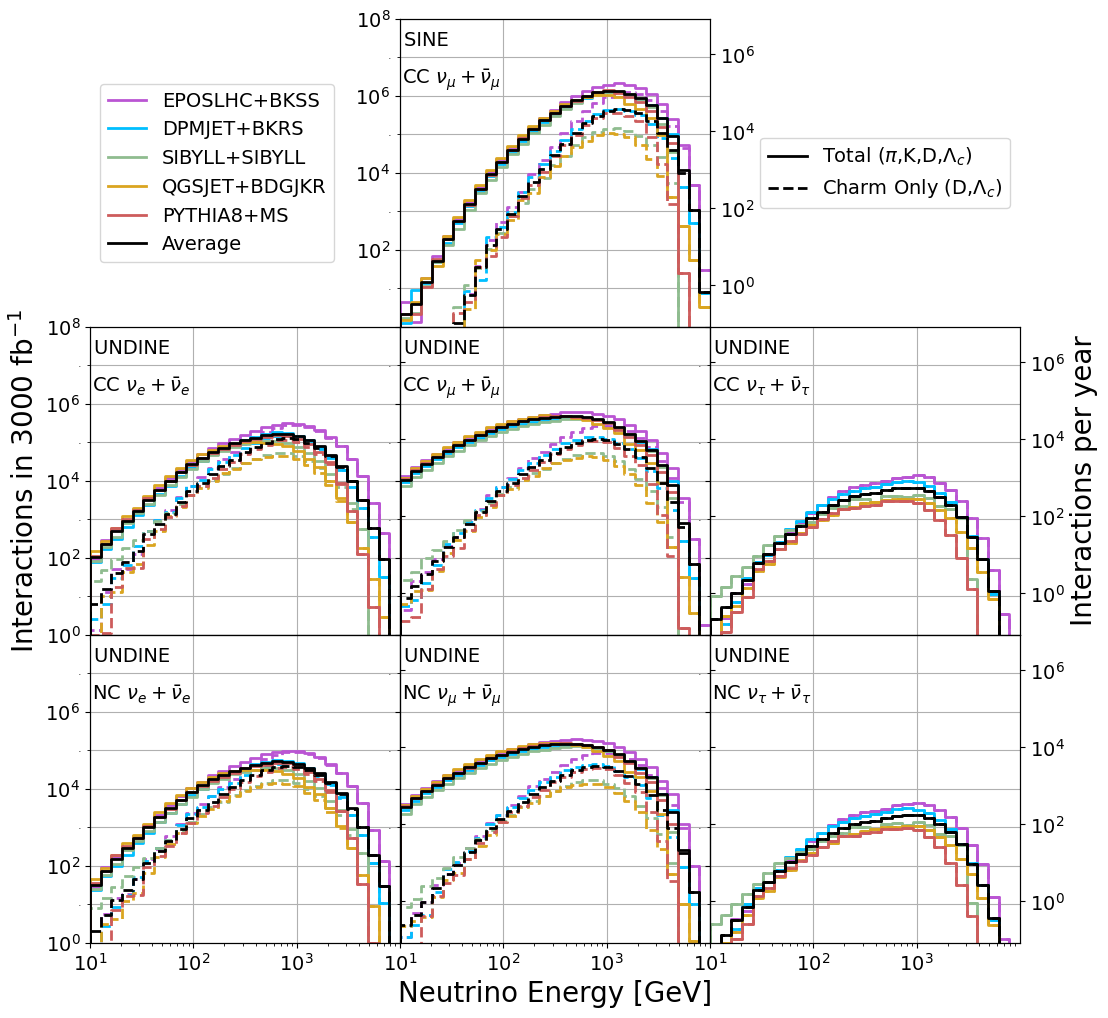

In [32]:
prefix = "LHC13"
light_generators = ["EPOSLHC","DPMJET","SIBYLL","QGSJET","PYTHIA8"]
charm_generators = ["BKSS","BKRS","SIBYLL","BDGJKR","MS"]

kaons = [
    130, # K0L
    310, # K0S
    321, # K+
    -321, # K-
    ]

pions = [
    211, # pi+
    -211 # pi-
]


fig,ax = plt.subplots(3,3,figsize=(12,12))
fig.set_facecolor("white")

twin_ax = np.empty_like(ax)
for i in range(3):
    for j in range(3):
        twin_ax[i,j] = ax[i,j].twinx()
        

fig.subplots_adjust(wspace=0, hspace=0)
ax[0,0].axis("off")
ax[0,2].axis("off")
twin_ax[0,0].axis("off")
twin_ax[0,2].axis("off")

Ebins = np.logspace(1,4,30)
pids = [12,14,16]

yearly_factor = 250./3000. # 250 fb^-1 per year / 3 ab^-1 total

total_rates = {}
generator_rates = {}
generator_pion_rates = {}
generator_kaon_rates = {}

SINE_numu_Erange = []
UNDINE_numu_Erange = []
UNDINE_nue_Erange = []

i = -1
for det,xs_models in datasets.items():
    
    for xs_model in xs_models:
        
        i += 1
        
        Ehist_l_avg = {pid:np.zeros(len(Ebins)-1) for pid in pids}
        Ehist_c_avg = {pid:np.zeros(len(Ebins)-1) for pid in pids}
        Ehist_avg = {pid:np.zeros(len(Ebins)-1) for pid in pids}

        for lg,cg in zip(light_generators,charm_generators):

            c = colors[(lg,cg)]
            print(lg,cg)

            lkey = tuple((det,xs_model,prefix,lg,"light"))
            ckey = tuple((det,xs_model,prefix,cg,"charm"))



            for iax,pid in enumerate(pids):



                if pid!=16 and not (pid!=14 and "SINE" in det):
                    ldata = ak.concatenate([data[lkey+(pid,)],data[lkey+(-pid,)]])
                    lweights = np.array(ldata.weights)
                    if "SINE" in det: lweights *= np.array(ldata.hit_mask_muon_survival)
                    if "UNDINE" in det: lweights *= num_UNDINE*np.array(ldata.in_fiducial)[:,-1]
                    #vx = np.squeeze(ldata.vertex)
                    Ehist_l,_ = np.histogram(ldata.energy,bins=Ebins,weights=lweights)
                    generator_rates[lkey+(pid,)] = sum(lweights)
                    pion_indices = np.isin(np.array(ldata.hPDG,dtype=int),pions)
                    kaon_indices = np.isin(np.array(ldata.hPDG,dtype=int),kaons)
                    pion_weights = lweights[pion_indices]
                    kaon_weights = lweights[kaon_indices]
                    generator_pion_rates[lkey+(pid,)] = sum(pion_weights)
                    generator_kaon_rates[lkey+(pid,)] = sum(kaon_weights)
                else:
                    Ehist_l = np.zeros(len(Ebins)-1)
                    generator_rates[lkey+(pid,)] = 0
                    generator_pion_rates[lkey+(pid,)] = 0
                    generator_kaon_rates[lkey+(pid,)] = 0
                if not (pid!=14 and "SINE" in det):
                    cdata = ak.concatenate([data[ckey+(pid,)],data[ckey+(-pid,)]])
                    cweights = np.array(cdata.weights)
                    if "SINE" in det: cweights *= np.array(cdata.hit_mask_muon_survival)
                    if "UNDINE" in det: cweights *= num_UNDINE*np.array(cdata.in_fiducial)[:,-1]
                    #vx = np.squeeze(cdata.vertex)
                    Ehist_c,_ = np.histogram(cdata.energy,bins=Ebins,weights=cweights)
                    generator_rates[ckey+(pid,)] = sum(cweights)
                    pion_indices = np.isin(np.array(cdata.hPDG,dtype=int),pions)
                    kaon_indices = np.isin(np.array(cdata.hPDG,dtype=int),kaons)
                    pion_weights = cweights[pion_indices]
                    kaon_weights = cweights[kaon_indices]
                    generator_pion_rates[ckey+(pid,)] = sum(pion_weights)
                    generator_kaon_rates[ckey+(pid,)] = sum(kaon_weights)
                else:
                    Ehist_c = np.zeros(len(Ebins)-1)
                    generator_rates[ckey+(pid,)] = 0
                    generator_pion_rates[ckey+(pid,)] = 0
                    generator_kaon_rates[ckey+(pid,)] = 0


                if cg=="BKRS" and xs_model=="CC":
                    q1 = 0.5 - 2*(1-norm.cdf(1))
                    q2 = 0.5 + 2*(1-norm.cdf(1))
                    if "SINE" in det and pid==14:
                        SINE_numu_Erange = weighted_quantile(list(ldata.energy)+list(cdata.energy),[q1,q2],sample_weight=list(lweights)+list(cweights))
                    if "UNDINE" in det and pid==12:
                        UNDINE_nue_Erange = weighted_quantile(list(ldata.energy)+list(cdata.energy),[q1,q2],sample_weight=list(lweights)+list(cweights))
                    if "UNDINE" in det and pid==14:
                        UNDINE_numu_Erange = weighted_quantile(list(ldata.energy)+list(cdata.energy),[q1,q2],sample_weight=list(lweights)+list(cweights))
                    
                            
                
                Ehist = np.array(Ehist_l+Ehist_c)
                Ehist_avg[pid] += Ehist/len(light_generators)
                Ehist_l_avg[pid] += np.array(Ehist_l)/len(light_generators)
                Ehist_c_avg[pid] += np.array(Ehist_c)/len(charm_generators)
                if i==0 and iax==0:
                    ax[i,iax].step([],[],color=c,label="%s+%s"%(lg,cg))
                elif i!=0 or iax !=2:
                    ax[i,iax].step(Ebins,np.append([0],Ehist),color=c,lw=2)
                    ax[i,iax].step(Ebins,np.append([0],Ehist_c),color=c,ls="--",lw=2)

        for iax,pid in enumerate(pids):
            total_rates[tuple((det,xs_model,"light",pid))] = sum(Ehist_l_avg[pid])
            total_rates[tuple((det,xs_model,"charm",pid))] = sum(Ehist_c_avg[pid])    
            if not(i==0 and iax!=1):
                ax[i,iax].step(Ebins,np.append([0],Ehist_c_avg[pid]),color="black",ls="--")
                ax[i,iax].step(Ebins,np.append([0],Ehist_avg[pid]),color="black")
            elif i==0 and iax==0:
                 ax[i,iax].plot([],[],label="Average",color="black")
            
ax[2,1].set_xlabel("Neutrino Energy [GeV]",fontsize=20)
ax[1,0].set_ylabel(r"Interactions in $3000~{\rm fb}^{-1}$",fontsize=20)
twin_ax[1,2].set_ylabel(r"Interactions per year",fontsize=20)
ax[0,2].plot([],[],color="black",label=r"Total ($\pi$,K,D,$\Lambda_c$)")
#ax[0,2].plot([],[],color="black",ls='--',label=r"$\pi$,K")
ax[0,2].plot([],[],color="black",ls='--',label=r"Charm Only (D,$\Lambda_c$)")
ax[0,0].legend(loc="center left",fontsize=14)
ax[0,2].legend(loc="center right",fontsize=14)

det_labels = ["SINE CC","UNDINE CC", "UNDINE NC"]
particle_labels = [r"$\nu_e+\bar{\nu}_e$",
                   r"$\nu_\mu+\bar{\nu}_\mu$",
                   r"$\nu_\tau+\bar{\nu}_\tau$"]
for i in [0,1,2]:
    for j in [0,1,2]:
            
        ax[i,j].set_xlim(1e1,Ebins[-1])
        ax[i,j].set_ylim(1e0,1e8)
        ax[i,j].set_xlim(1e1,1e4)
        ax[i,j].tick_params(axis='both', which='major', labelsize=14)
        ax[i,j].tick_params(axis='both', which='minor', labelsize=0)
        twin_ax[i,j].tick_params(axis='both', which='major', labelsize=14)
        ax[i,j].get_xaxis().grid(True,which='major')
        ax[i,j].get_yaxis().grid(True,which='both')
        
        if not(i==0 and j in [0,2]):
            ax[i,j].text(11,2e7,det_labels[i][:-2],fontsize=14)
            ax[i,j].text(10.5,2e6,det_labels[i][-2:]+" "+ particle_labels[j],fontsize=14)
            ax[i,j].loglog()
            mn, mx = ax[i,j].get_ylim()
            twin_ax[i,j].set_ylim(mn*yearly_factor, mx*yearly_factor)
            twin_ax[i,j].loglog()
        
        # xticks
        if i!=2: 
            ax[i,j].set_xticklabels([])
        if i!= 0: 
            ax[i,j].set_xticks(np.logspace(1,3,3))
        
        # yticks
        if i==0 and j==1:
            ax[i,j].set_yticks(np.logspace(2,8,4))
            ax[i,j].set_yticks(np.logspace(1,8,8),minor=True)
        elif i==1 and j==0:
            ax[i,j].set_yticks(np.logspace(0,8,5))
            ax[i,j].set_yticks(np.logspace(0,8,9),minor=True)
        elif i==2 and j==0:
            ax[i,j].set_yticks(np.logspace(0,6,4))
            ax[i,j].set_yticks(np.logspace(0,7,8),minor=True)
        else:
            ax[i,j].set_yticks(np.logspace(0,8,9),minor=True)
            ax[i,j].set_yticklabels([])
        
        if (i==0 and j==1) or (j==2 and i in [1,2]):
            twin_ax[i,j].set_yticks(np.logspace(0,6,4))
        else:
            twin_ax[i,j].set_yticklabels([])

plt.savefig("Figures/SIREN/Distributions.pdf",dpi=100)
plt.show()
            

In [4]:
for detector,xs_models in datasets.items():
    for xs_model in xs_models:
        if xs_model=="NC":
            rate_light = 0
            rate_charm = 0
            for pid in pids:
                rate_light += total_rates[tuple((detector,xs_model,"light",pid))]
                rate_charm += total_rates[tuple((detector,xs_model,"charm",pid))]
            print("%s (%s %s) & %s & %s & %s \\\\"%("SINE" if "SINE" in detector else "UNDINE",
                                               xs_model,"$\\nu_\\alpha + \\bar{\\nu}_\\alpha$",
                                               "$10^{%1.2f}$"%np.log10(rate_light+rate_charm),
                                               "$10^{%1.2f}$"%np.log10(rate_light) if rate_light > 0 else "0",
                                               "$10^{%1.2f}$"%np.log10(rate_charm)))
        else:
            for pid,pid_label in zip(pids,particle_labels):
                if pid!=14 and "SINE" in detector: continue
                rate_light = total_rates[tuple((detector,xs_model,"light",pid))]
                rate_charm = total_rates[tuple((detector,xs_model,"charm",pid))]

                print("%s (%s %s) & %s & %s & %s \\\\"%("SINE" if "SINE" in detector else "UNDINE",
                       xs_model,pid_label,
                       "$10^{%1.2f}$"%np.log10(rate_light+rate_charm),
                       "$10^{%1.2f}$"%np.log10(rate_light) if rate_light > 0 else "0",
                       "$10^{%1.2f}$"%np.log10(rate_charm)))
                

SINE (CC $\nu_\mu+\bar{\nu}_\mu$) & $10^{7.00}$ & $10^{6.87}$ & $10^{6.44}$ \\
UNDINE (CC $\nu_e+\bar{\nu}_e$) & $10^{6.17}$ & $10^{5.73}$ & $10^{5.97}$ \\
UNDINE (CC $\nu_\mu+\bar{\nu}_\mu$) & $10^{6.75}$ & $10^{6.68}$ & $10^{5.96}$ \\
UNDINE (CC $\nu_\tau+\bar{\nu}_\tau$) & $10^{4.79}$ & 0 & $10^{4.79}$ \\
UNDINE (NC $\nu_\alpha + \bar{\nu}_\alpha$) & $10^{6.35}$ & $10^{6.22}$ & $10^{5.78}$ \\


# Charm production model sensitivity

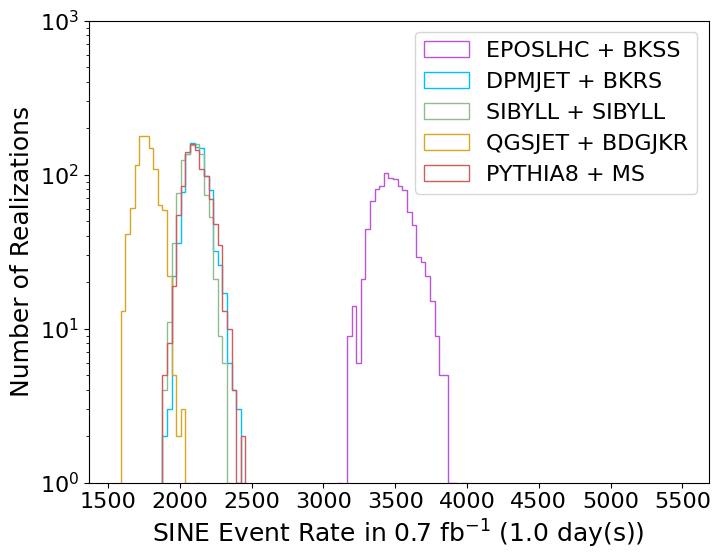

In [5]:

exposure_factor = 1./4400. # roughly one month
r1_unc = {}
r2_unc = {}
pseudoexp_dir = "/n/holylfs05/LABS/arguelles_delgado_lab/Everyone/nkamp/Geneva/Lake_Geneva_Neutrinos/Data/SIREN/Output/Pseudoexperiments"
for lg,cg in zip(light_generators,charm_generators):
    c = colors[(lg,cg)]
    SINE_Total = np.load("%s/SINE_Total_All_%s_%s.npy"%(pseudoexp_dir,lg,cg))
    UNDINE_Total = num_UNDINE*np.load("%s/UNDINE_Total_All_%s_%s.npy"%(pseudoexp_dir,lg,cg))
    UNDINE_muons = num_UNDINE*np.load("%s/UNDINE_muons_All_%s_%s.npy"%(pseudoexp_dir,lg,cg))
    UNDINE_electrons = num_UNDINE*np.load("%s/UNDINE_electrons_All_%s_%s.npy"%(pseudoexp_dir,lg,cg))
    SINE_Total_realizations = np.random.poisson(lam=exposure_factor*SINE_Total)
    UNDINE_Total_realizations = np.random.poisson(lam=exposure_factor*UNDINE_Total)
    UNDINE_muons_realizations = np.random.poisson(lam=exposure_factor*UNDINE_muons)
    UNDINE_electrons_realizations = np.random.poisson(lam=exposure_factor*UNDINE_electrons)
    #print(SINE_Total,SINE_Total_realizations)
    plt.hist(SINE_Total_realizations,bins=np.linspace(exposure_factor*6e6,exposure_factor*2e7,100),color=c,histtype="step",label="%s + %s"%(lg,cg))
    r1 = np.sort(SINE_Total/UNDINE_Total,)
    r2 = np.sort(UNDINE_muons/UNDINE_electrons)
    r1_unc[(lg,cg)] = {}
    r2_unc[(lg,cg)] = {}
    for sigma in [1,2,3]:
        low_cl = (2*(1-norm.cdf(sigma)))
        high_cl = 1 - low_cl
        for r,r_unc in zip([r1,r2],[r1_unc[(lg,cg)],r2_unc[(lg,cg)]]):
            r_down = np.median(r) - r[int(low_cl*len(r))]
            r_up = r[int(high_cl*len(r))] - np.median(r)
            r_unc[sigma] = (r_down,r_up)
plt.xlim(exposure_factor*6e6,exposure_factor*2.5e7)
plt.ylim(1,1e3)
plt.semilogy()
plt.xlabel(r"SINE Event Rate in %2.1f fb$^{-1}$ (%2.1f day(s))"%(3000*exposure_factor,exposure_factor/yearly_factor*365))
plt.ylabel("Number of Realizations")
plt.legend(loc="upper right")
plt.show()

EPOSLHC BKSS
DPMJET BKRS
SIBYLL SIBYLL
QGSJET BDGJKR
PYTHIA8 MS


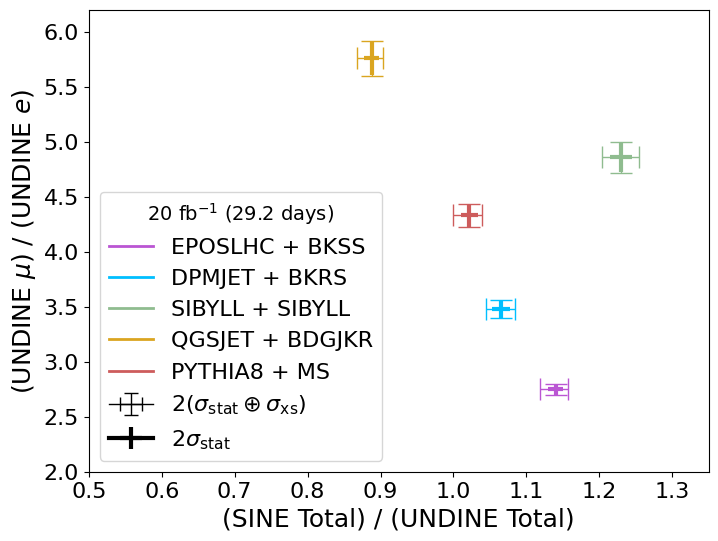

In [6]:
tau_muon_BR = 0.1739
norm_error = 0.03
exposure_factor = 1./150. # roughly one month
nsigma = 2

SINE_rate_nominal = {}
UNDINE_rate_nominal = {}
UNDINE_muons_nominal = {}
UNDINE_electrons_nominal = {}
for lg,cg in zip(light_generators,charm_generators):

    c = colors[(lg,cg)]
    print(lg,cg)
    
    SINE_rate_nominal[(lg,cg)] = {}
    UNDINE_rate_nominal[(lg,cg)] = {}
    UNDINE_muons_nominal[(lg,cg)] = {}
    UNDINE_electrons_nominal[(lg,cg)] = {}

    # SINE overall rate
    lkey = tuple(("SINE_CMS_West","CC",prefix,lg,"light"))
    ckey = tuple(("SINE_CMS_West","CC",prefix,cg,"charm"))
    SINE_rate = generator_rates[lkey+(14,)] + generator_rates[ckey+(14,)]
    SINE_rate_pions = generator_pion_rates[lkey+(14,)] + generator_pion_rates[ckey+(14,)]
    SINE_rate_kaons = generator_kaon_rates[lkey+(14,)] + generator_kaon_rates[ckey+(14,)]

    # UNDINE overall rate
    UNDINE_rate = 0
    UNDINE_muons = 0
    UNDINE_electrons = 0
    UNDINE_rate_pions = 0
    UNDINE_muons_pions = 0
    UNDINE_electrons_pions = 0
    UNDINE_rate_kaons = 0
    UNDINE_muons_kaons = 0
    UNDINE_electrons_kaons = 0
    for xs_model in datasets["UNDINE_CMS_East"]:
        lkey = tuple(("UNDINE_CMS_East",xs_model,prefix,lg,"light"))
        ckey = tuple(("UNDINE_CMS_East",xs_model,prefix,cg,"charm"))
        for pid in pids:
            rate = generator_rates[lkey+(pid,)] + generator_rates[ckey+(pid,)]
            pion_rate = generator_pion_rates[lkey+(pid,)] + generator_pion_rates[ckey+(pid,)]
            kaon_rate = generator_kaon_rates[lkey+(pid,)] + generator_kaon_rates[ckey+(pid,)]
            UNDINE_rate += rate
            UNDINE_rate_pions += pion_rate
            UNDINE_rate_kaons += kaon_rate
            if xs_model=="CC" and pid==14:
                UNDINE_muons += rate
                UNDINE_muons_pions += pion_rate
                UNDINE_muons_kaons += kaon_rate
            if xs_model=="CC" and pid==16:
                UNDINE_muons += tau_muon_BR*rate
                UNDINE_muons_pions += tau_muon_BR*pion_rate
                UNDINE_muons_kaons += tau_muon_BR*kaon_rate
            if xs_model=="CC" and pid==12:
                UNDINE_electrons += rate
                UNDINE_electrons_pions += pion_rate
                UNDINE_electrons_kaons += kaon_rate
    
    SINE_rate_nominal[(lg,cg)]["All"] = SINE_rate
    UNDINE_rate_nominal[(lg,cg)]["All"] = UNDINE_rate
    UNDINE_muons_nominal[(lg,cg)]["All"] = UNDINE_muons
    UNDINE_electrons_nominal[(lg,cg)]["All"] = UNDINE_electrons
    
    SINE_rate_nominal[(lg,cg)]["Pions"] = SINE_rate_pions
    UNDINE_rate_nominal[(lg,cg)]["Pions"] = UNDINE_rate_pions
    UNDINE_muons_nominal[(lg,cg)]["Pions"] = UNDINE_muons_pions
    UNDINE_electrons_nominal[(lg,cg)]["Pions"] = UNDINE_electrons_pions
    
    SINE_rate_nominal[(lg,cg)]["Kaons"] = SINE_rate_kaons
    UNDINE_rate_nominal[(lg,cg)]["Kaons"] = UNDINE_rate_kaons
    UNDINE_muons_nominal[(lg,cg)]["Kaons"] = UNDINE_muons_kaons
    UNDINE_electrons_nominal[(lg,cg)]["Kaons"] = UNDINE_electrons_kaons
    
    SINE_rate *= exposure_factor
    UNDINE_rate *= exposure_factor
    UNDINE_muons *= exposure_factor
    UNDINE_electrons *= exposure_factor
    
    r1 = SINE_rate / UNDINE_rate
    r2 = UNDINE_muons / UNDINE_electrons
    #r1_err = r1 * np.sqrt((norm_error*SINE_rate/SINE_rate)**2 + (norm_error*total_lake/total_lake)**2)
    #r2_err = r2 * np.sqrt((norm_error*tracks_lake/tracks_lake)**2 + (norm_error*cascades_lake/cascades_lake)**2)
    r1_xs_err = list(r1_unc[(lg,cg)][nsigma])
    r2_xs_err = list(r2_unc[(lg,cg)][nsigma])
    
    r1_stat_err = nsigma * r1 * np.sqrt(1/SINE_rate + 1/UNDINE_rate)
    r2_stat_err = nsigma * r2 * np.sqrt(1/UNDINE_muons + 1/UNDINE_electrons)
    
    r1_err_low = np.sqrt(r1_stat_err**2 + r1_xs_err[0]**2)
    r1_err_high = np.sqrt(r1_stat_err**2 + r1_xs_err[1]**2)
    r2_err_low = np.sqrt(r2_stat_err**2 + r2_xs_err[0]**2)
    r2_err_high = np.sqrt(r2_stat_err**2 + r2_xs_err[1]**2)
    
    plt.errorbar(r1,r2,
                 xerr=r1_stat_err,
                 yerr=r2_stat_err,
                 color=c,lw=3)
    plt.errorbar(r1,r2,
                 xerr=np.expand_dims((r1_err_low,r1_err_high),-1),
                 yerr=np.expand_dims((r2_err_low,r2_err_high),-1),
                 color=c,lw=1,capsize=8)
    #for cap in caplines: cap.set_marker('v')
    plt.plot([],[],color=c,label="%s + %s"%(lg,cg))
    
    
plt.errorbar([-1],[-1],xerr=[2],yerr=[2],color="black",lw=1,capsize=5,label=r"$%d (\sigma_{\rm stat} \oplus \sigma_{\rm xs})$"%nsigma)
plt.errorbar([],[],xerr=[],yerr=[],color="black",lw=3,label=r"$%d \sigma_{\rm stat}$"%nsigma)
plt.legend(title=r"%d ${\rm fb}^{-1}$ (%2.1f days)"%(3000*exposure_factor,exposure_factor/yearly_factor*365),loc="lower left")
plt.xlim(0.5,1.35)
plt.ylim(2,6.2)
plt.xlabel("(SINE Total) / (UNDINE Total)")
plt.ylabel(r"(UNDINE $\mu$) / (UNDINE $e$)")
plt.gcf().set_facecolor("white")
plt.gcf().patch.set_alpha(0.0)
plt.savefig("Figures/SIREN/GeneratorDifferntiator.pdf",dpi=100)
plt.show()

# Cross section sensitivity

In [7]:
import siren

numu = (siren.dataclasses.Particle.ParticleType)(14)
nue = (siren.dataclasses.Particle.ParticleType)(12)
numubar = (siren.dataclasses.Particle.ParticleType)(-14)
nuebar = (siren.dataclasses.Particle.ParticleType)(-12)

cross_section_model = "CSMSDISSplines"

xsfiledir = siren.utilities.get_cross_section_model_path(cross_section_model)

# Cross Section Model
target_type = siren.dataclasses.Particle.ParticleType.Nucleon

numu_CC = siren.interactions.DISFromSpline(
    os.path.join(xsfiledir, "dsdxdy_nu_CC_iso.fits"),
    os.path.join(xsfiledir, "sigma_nu_CC_iso.fits"),
    [numu],
    [target_type], "m"
)

numubar_CC = siren.interactions.DISFromSpline(
    os.path.join(xsfiledir, "dsdxdy_nubar_CC_iso.fits"),
    os.path.join(xsfiledir, "sigma_nubar_CC_iso.fits"),
    [numubar],
    [target_type], "m"
)

nue_CC = siren.interactions.DISFromSpline(
    os.path.join(xsfiledir, "dsdxdy_nu_CC_iso.fits"),
    os.path.join(xsfiledir, "sigma_nu_CC_iso.fits"),
    [nue],
    [target_type], "m"
)

nuebar_CC = siren.interactions.DISFromSpline(
    os.path.join(xsfiledir, "dsdxdy_nubar_CC_iso.fits"),
    os.path.join(xsfiledir, "sigma_nubar_CC_iso.fits"),
    [nuebar],
    [target_type], "m"
)
erange = np.logspace(1,4,100)
numu_CC_xs = [numu_CC.TotalCrossSection(numu,e) for e in erange]
numubar_CC_xs = [numubar_CC.TotalCrossSection(numubar,e) for e in erange]
nue_CC_xs = [nue_CC.TotalCrossSection(nue,e) for e in erange]
nuebar_CC_xs = [nuebar_CC.TotalCrossSection(nuebar,e) for e in erange]

56.47552945324565 0.13306684025980592


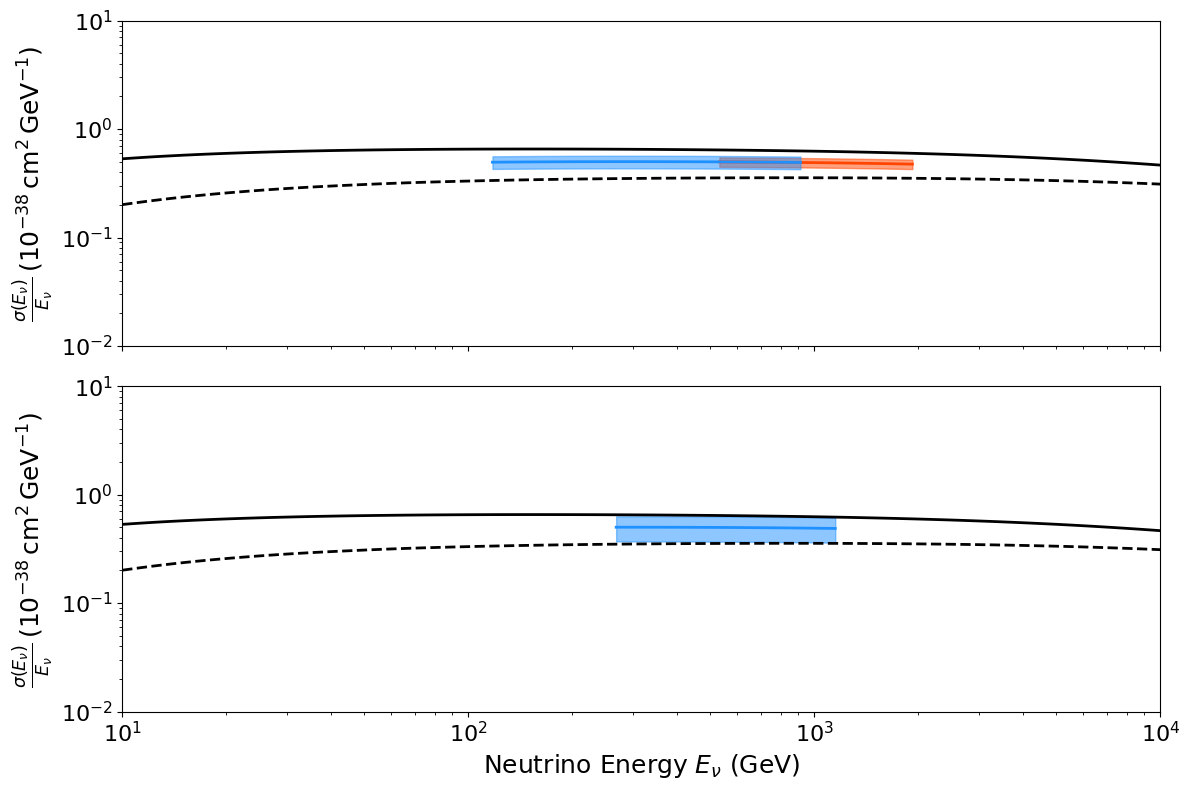

In [68]:
exposure_factor = 1./300000
n_sigma=3

fig,ax = plt.subplots(2,1,sharex=True,figsize=(12,8))
fig.subplots_adjust(hspace=0)

SINE_numu_n = n_sigma*exposure_factor*(total_rates["SINE_CMS_West",'CC','light',14] + total_rates["SINE_CMS_West",'CC','charm',14])
UNDINE_numu_n = n_sigma*exposure_factor*(total_rates["UNDINE_CMS_East",'CC','light',14] + total_rates["UNDINE_CMS_East",'CC','charm',14])
UNDINE_nue_n = n_sigma*exposure_factor*(total_rates["UNDINE_CMS_East",'CC','light',12] + total_rates["UNDINE_CMS_East",'CC','charm',12])

SINE_numu_stat_err = 1./np.sqrt(SINE_numu_n)
UNDINE_numu_stat_err = 1./np.sqrt(UNDINE_numu_n)
print(UNDINE_numu_n,UNDINE_numu_stat_err)
UNDINE_nue_stat_err = 1./np.sqrt(UNDINE_nue_n)


ax[0].plot(erange,numu_CC_xs/erange/1e-38,color="black",ls="-")
ax[0].plot(erange,numubar_CC_xs/erange/1e-38,color="black",ls="--")
SINE_numu_Erange_arr = np.linspace(*SINE_numu_Erange,100)
SINE_numu_avg_xsec = [0.5*(numu_CC.TotalCrossSection(numu,e) + numubar_CC.TotalCrossSection(numubar,e)) for e in SINE_numu_Erange_arr]
ax[0].plot(SINE_numu_Erange_arr,SINE_numu_avg_xsec/SINE_numu_Erange_arr/1e-38,color="orangered")
ax[0].fill_between(SINE_numu_Erange_arr,
                   (1-SINE_numu_stat_err)*(SINE_numu_avg_xsec/SINE_numu_Erange_arr/1e-38),
                   (1+SINE_numu_stat_err)*(SINE_numu_avg_xsec/SINE_numu_Erange_arr/1e-38),
                   color="orangered",alpha=0.5)
UNDINE_numu_Erange_arr = np.linspace(*UNDINE_numu_Erange,100)
UNDINE_numu_avg_xsec = [0.5*(numu_CC.TotalCrossSection(numu,e) + numubar_CC.TotalCrossSection(numubar,e)) for e in UNDINE_numu_Erange_arr]
ax[0].plot(UNDINE_numu_Erange_arr,UNDINE_numu_avg_xsec/UNDINE_numu_Erange_arr/1e-38,color="dodgerblue")
ax[0].fill_between(UNDINE_numu_Erange_arr,
                   (1-UNDINE_numu_stat_err)*(UNDINE_numu_avg_xsec/UNDINE_numu_Erange_arr/1e-38),
                   (1+UNDINE_numu_stat_err)*(UNDINE_numu_avg_xsec/UNDINE_numu_Erange_arr/1e-38),
                   color="dodgerblue",alpha=0.5)
ax[0].loglog()
ax[0].set_ylim(1e-2,1e1)
ax[0].set_ylabel(r"$\frac{\sigma(E_\nu)}{E_\nu}\,(10^{-38}\,{\rm cm}^2\,{\rm GeV}^{-1})$ ")

ax[1].plot(erange,nue_CC_xs/erange/1e-38,color="black",ls="-")
ax[1].plot(erange,nuebar_CC_xs/erange/1e-38,color="black",ls="--")
UNDINE_nue_Erange_arr = np.linspace(*UNDINE_nue_Erange,100)
UNDINE_nue_avg_xsec = [0.5*(nue_CC.TotalCrossSection(nue,e) + nuebar_CC.TotalCrossSection(nuebar,e)) for e in UNDINE_nue_Erange_arr]
ax[1].plot(UNDINE_nue_Erange_arr,UNDINE_nue_avg_xsec/UNDINE_nue_Erange_arr/1e-38,color="dodgerblue")
ax[1].fill_between(UNDINE_nue_Erange_arr,
                   (1-UNDINE_nue_stat_err)*(UNDINE_nue_avg_xsec/UNDINE_nue_Erange_arr/1e-38),
                   (1+UNDINE_nue_stat_err)*(UNDINE_nue_avg_xsec/UNDINE_nue_Erange_arr/1e-38),
                   color="dodgerblue",alpha=0.5)
ax[1].loglog()
ax[1].set_ylim(1e-2,1e1)
ax[1].set_xlim(erange[0],erange[-1])
ax[1].set_ylabel(r"$\frac{\sigma(E_\nu)}{E_\nu}\,(10^{-38}\,{\rm cm}^2\,{\rm GeV}^{-1})$ ")
ax[1].set_xlabel(r"Neutrino Energy $E_\nu$ (GeV)")

plt.tight_layout()
plt.show()

# Strangeness Enhancement Sensitivity
Following https://arxiv.org/abs/2309.10417

In [9]:
from scipy.special import gammaln

def rate_likelihood(SINE_Total_k,UNDINE_Total_k,UNDINE_muons_k,UNDINE_electrons_k,
                    SINE_Total_mu,UNDINE_Total_mu,UNDINE_muons_mu,UNDINE_electrons_mu,
                    mu_dim=2):
    N_mu = SINE_Total_mu.shape[-1]
    #print("SINE_Total_k",SINE_Total_k.shape)
    #       "\nUNDINE_Total_k",UNDINE_Total_k,
    #       "\nUNDINE_muons_k",UNDINE_muons_k,
    #       "\nUNDINE_electrons_k",UNDINE_electrons_k)
    #print("SINE_Total_mu",SINE_Total_mu.shape)
    #       "\nUNDINE_Total_mu",UNDINE_Total_mu,
    #       "\nUNDINE_muons_mu",UNDINE_muons_mu,
    #       "\nUNDINE_electrons_mu",UNDINE_electrons_mu)
    # print(poisson.pmf(SINE_Total_k,SINE_Total_mu))
    # print(poisson.pmf(UNDINE_Total_k,UNDINE_Total_mu))
    # print(poisson.pmf(UNDINE_muons_k,UNDINE_muons_k))
    # print(poisson.pmf(UNDINE_electrons_k,UNDINE_electrons_mu))
    logL = np.log(1./N_mu) * np.ones_like(SINE_Total_k)
    for k,mu in zip([SINE_Total_k,UNDINE_Total_k,UNDINE_muons_k,UNDINE_electrons_k],
                    [SINE_Total_mu,UNDINE_Total_mu,UNDINE_muons_mu,UNDINE_electrons_mu]):
        logL_arr = np.einsum('...j,...k->...jk',k,mu)
        logL_arr -= np.expand_dims(mu,axis=1)
        logL_arr -= np.expand_dims(gammaln(k),axis=2)
        m = np.max(logL_arr,axis=mu_dim)
        logL += (m + np.log(np.sum(np.exp(logL_arr-np.expand_dims(m,mu_dim)),axis=mu_dim)))
    return logL
    # return poisson.pmf(SINE_Total_k,SINE_Total_mu) * poisson.pmf(UNDINE_Total_k,UNDINE_Total_mu)  * \
    #        poisson.pmf(UNDINE_muons_k,UNDINE_muons_mu) * poisson.pmf(UNDINE_electrons_k,UNDINE_electrons_mu)
    

EPOSLHC BKSS
DPMJET BKRS
SIBYLL SIBYLL
QGSJET BDGJKR
PYTHIA8 MS


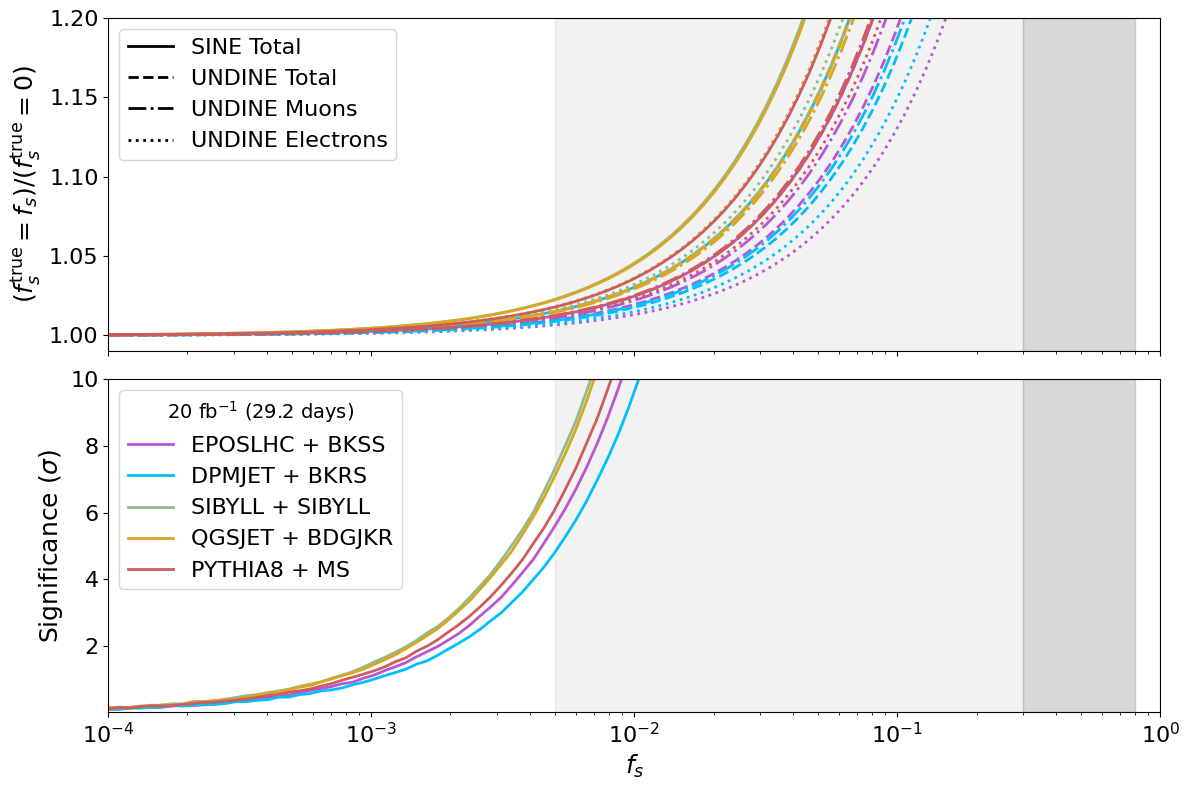

In [10]:


n_fs = 100
fs_range = np.logspace(-4,0,n_fs)
nsigma=1
low_cl = (2*(1-norm.cdf(nsigma)))
high_cl = 1 - low_cl
exposure_factor = 1./150 # roughly one month
n_mu_samples = 1
n_k_samples = 10000
mu_mean_mode = True

fig,ax = plt.subplots(2,1,sharex=True,figsize=(12,8))
fig.subplots_adjust(hspace=0)

for lg,cg in zip(light_generators,charm_generators):
    print(lg,cg)
    c = colors[(lg,cg)]
    SINE_Total = {}
    UNDINE_Total = {}
    UNDINE_muons = {}
    UNDINE_electrons = {}
    mu_random_idxs = np.random.choice(range(len(np.load("%s/SINE_Total_%s_%s_%s.npy"%(pseudoexp_dir,"All",lg,cg)))),size=n_mu_samples)
    for k in ["All","Pions","Kaons"]:
        SINE_Total[k] = exposure_factor*np.load("%s/SINE_Total_%s_%s_%s.npy"%(pseudoexp_dir,k,lg,cg))
        UNDINE_Total[k] = exposure_factor*num_UNDINE*np.load("%s/UNDINE_Total_%s_%s_%s.npy"%(pseudoexp_dir,k,lg,cg))
        UNDINE_muons[k] = exposure_factor*num_UNDINE*np.load("%s/UNDINE_muons_%s_%s_%s.npy"%(pseudoexp_dir,k,lg,cg))
        UNDINE_electrons[k] = exposure_factor*num_UNDINE*np.load("%s/UNDINE_electrons_%s_%s_%s.npy"%(pseudoexp_dir,k,lg,cg))
        if mu_mean_mode:
            SINE_Total[k] = np.array([np.mean(SINE_Total[k])])
            UNDINE_Total[k] = np.array([np.mean(UNDINE_Total[k])])
            UNDINE_muons[k] = np.array([np.mean(UNDINE_muons[k])])
            UNDINE_electrons[k] = np.array([np.mean(UNDINE_electrons[k])])
        else:
            SINE_Total[k] = SINE_Total[k][mu_random_idxs]
            UNDINE_Total[k] = UNDINE_Total[k][mu_random_idxs]
            UNDINE_muons[k] = UNDINE_muons[k][mu_random_idxs]
            UNDINE_electrons[k] = UNDINE_electrons[k][mu_random_idxs]
            
    
    SINE_Total_diff = np.outer(6.6*fs_range,SINE_Total["Kaons"]) - np.outer(fs_range,SINE_Total["Pions"])
    SINE_Total_mu_null = SINE_Total["All"]
    SINE_Total_mu_alt = (np.expand_dims(SINE_Total["All"],0) + SINE_Total_diff)
    SINE_Total_k_alt = np.random.poisson(lam=np.expand_dims(SINE_Total_mu_alt,-1),size=(n_fs,n_mu_samples,n_k_samples)).reshape(n_fs,n_mu_samples*n_k_samples)
    SINE_Total_k_null = np.random.poisson(lam=np.expand_dims(SINE_Total_mu_null,-1),size=(n_mu_samples,n_k_samples)).reshape(n_mu_samples*n_k_samples)
    
    UNDINE_Total_diff = np.outer(6.6*fs_range,UNDINE_Total["Kaons"]) - np.outer(fs_range,UNDINE_Total["Pions"])
    UNDINE_Total_mu_null = UNDINE_Total["All"]
    UNDINE_Total_mu_alt = (np.expand_dims(UNDINE_Total["All"],0) + UNDINE_Total_diff)
    UNDINE_Total_k_alt = np.random.poisson(lam=np.expand_dims(UNDINE_Total_mu_alt,-1),size=(n_fs,n_mu_samples,n_k_samples)).reshape(n_fs,n_mu_samples*n_k_samples)
    UNDINE_Total_k_null = np.random.poisson(lam=np.expand_dims(UNDINE_Total_mu_null,-1),size=(n_mu_samples,n_k_samples)).reshape(n_mu_samples*n_k_samples)
    
    UNDINE_muons_diff = np.outer(6.6*fs_range,UNDINE_muons["Kaons"]) - np.outer(fs_range,UNDINE_muons["Pions"])
    UNDINE_muons_mu_null = UNDINE_muons["All"]
    UNDINE_muons_mu_alt = (np.expand_dims(UNDINE_muons["All"],0) + UNDINE_muons_diff)
    UNDINE_muons_k_alt = np.random.poisson(lam=np.expand_dims(UNDINE_muons_mu_alt,-1),size=(n_fs,n_mu_samples,n_k_samples)).reshape(n_fs,n_mu_samples*n_k_samples)
    UNDINE_muons_k_null = np.random.poisson(lam=np.expand_dims(UNDINE_muons_mu_null,-1),size=(n_mu_samples,n_k_samples)).reshape(n_mu_samples*n_k_samples)
    
    UNDINE_electrons_diff = np.outer(6.6*fs_range,UNDINE_electrons["Kaons"]) - np.outer(fs_range,UNDINE_electrons["Pions"])
    UNDINE_electrons_mu_null = UNDINE_electrons["All"]
    UNDINE_electrons_mu_alt = (np.expand_dims(UNDINE_electrons["All"],0) + UNDINE_electrons_diff)
    UNDINE_electrons_k_alt = np.random.poisson(lam=np.expand_dims(UNDINE_electrons_mu_alt,-1),size=(n_fs,n_mu_samples,n_k_samples)).reshape(n_fs,n_mu_samples*n_k_samples)
    UNDINE_electrons_k_null = np.random.poisson(lam=np.expand_dims(UNDINE_electrons_mu_null,-1),size=(n_mu_samples,n_k_samples)).reshape(n_mu_samples*n_k_samples)
    
    # print("k_alt",np.mean(SINE_Total_k_alt,axis=-1))
    # print("k_null",np.mean(SINE_Total_k_null))
    # print("mu_alt",np.mean(SINE_Total_mu_alt,axis=-1))
    # print("mu_null",np.median(SINE_Total_mu_null),np.sqrt(np.median(SINE_Total_mu_null)))
    
#     SINE_Total_mu_null = exposure_factor*SINE_rate_nominal[(lg,cg)]["All"]
#     UNDINE_Total_mu_null = exposure_factor*UNDINE_rate_nominal[(lg,cg)]["All"]
#     UNDINE_electrons_mu_null = exposure_factor*UNDINE_electrons_nominal[(lg,cg)]["All"]
#     UNDINE_muons_mu_null = exposure_factor*UNDINE_muons_nominal[(lg,cg)]["All"]
    
#     SINE_Total_mu_alt = exposure_factor*np.expand_dims(SINE_rate_nominal[(lg,cg)]["All"],0) + np.outer(6.6*fs_range,SINE_rate_nominal[(lg,cg)]["Pions"]) - np.outer(fs_range,SINE_rate_nominal[(lg,cg)]["Kaons"])
#     UNDINE_Total_mu_alt = exposure_factor*np.expand_dims(UNDINE_rate_nominal[(lg,cg)]["All"],0) + np.outer(6.6*fs_range,UNDINE_rate_nominal[(lg,cg)]["Pions"]) - np.outer(fs_range,UNDINE_rate_nominal[(lg,cg)]["Kaons"])
#     UNDINE_electrons_mu_alt = exposure_factor*np.expand_dims(UNDINE_electrons_nominal[(lg,cg)]["All"],0) + np.outer(6.6*fs_range,UNDINE_electrons_nominal[(lg,cg)]["Pions"]) - np.outer(fs_range,UNDINE_electrons_nominal[(lg,cg)]["Kaons"])
#     UNDINE_muons_mu_alt = exposure_factor*np.expand_dims(UNDINE_muons_nominal[(lg,cg)]["All"],0) + np.outer(6.6*fs_range,UNDINE_muons_nominal[(lg,cg)]["Pions"]) - np.outer(fs_range,UNDINE_muons_nominal[(lg,cg)]["Kaons"])
    
    likelihood_null_null = rate_likelihood(SINE_Total_k=np.expand_dims(SINE_Total_k_null,0),
                                           UNDINE_Total_k=np.expand_dims(UNDINE_Total_k_null,0),
                                           UNDINE_muons_k=np.expand_dims(UNDINE_muons_k_null,0),
                                           UNDINE_electrons_k=np.expand_dims(UNDINE_electrons_k_null,0),
                                           SINE_Total_mu=np.expand_dims(SINE_Total_mu_null,0),
                                           UNDINE_Total_mu=np.expand_dims(UNDINE_Total_mu_null,0),
                                           UNDINE_muons_mu=np.expand_dims(UNDINE_muons_mu_null,0),
                                           UNDINE_electrons_mu=np.expand_dims(UNDINE_electrons_mu_null,0)
                                          )
    
    #print('nn',likelihood_null_null.shape)
    
    likelihood_null_alt = rate_likelihood(SINE_Total_k=np.repeat(np.expand_dims(SINE_Total_k_null,0),n_fs,axis=0),
                                          UNDINE_Total_k=np.repeat(np.expand_dims(UNDINE_Total_k_null,0),n_fs,axis=0),
                                          UNDINE_muons_k=np.repeat(np.expand_dims(UNDINE_muons_k_null,0),n_fs,axis=0),
                                          UNDINE_electrons_k=np.repeat(np.expand_dims(UNDINE_electrons_k_null,0),n_fs,axis=0),
                                          SINE_Total_mu=SINE_Total_mu_alt,
                                          UNDINE_Total_mu=UNDINE_Total_mu_alt,
                                          UNDINE_muons_mu=UNDINE_muons_mu_alt,
                                          UNDINE_electrons_mu=UNDINE_electrons_mu_alt
                                         )
    
    #print('na',likelihood_null_alt.shape)
    
    likelihood_alt_null = rate_likelihood(SINE_Total_k=SINE_Total_k_alt,
                                          UNDINE_Total_k=UNDINE_Total_k_alt,
                                          UNDINE_muons_k=UNDINE_muons_k_alt,
                                          UNDINE_electrons_k=UNDINE_electrons_k_alt,
                                          SINE_Total_mu=np.repeat(np.expand_dims(SINE_Total_mu_null,axis=0),n_fs,axis=0),
                                          UNDINE_Total_mu=np.repeat(np.expand_dims(UNDINE_Total_mu_null,axis=0),n_fs,axis=0),
                                          UNDINE_muons_mu=np.repeat(np.expand_dims(UNDINE_muons_mu_null,axis=0),n_fs,axis=0),
                                          UNDINE_electrons_mu=np.repeat(np.expand_dims(UNDINE_electrons_mu_null,axis=0),n_fs,axis=0)
                                         )
    
    #print('an',likelihood_alt_null.shape)
    
    likelihood_alt_alt = rate_likelihood(SINE_Total_k=SINE_Total_k_alt,
                                         UNDINE_Total_k=UNDINE_Total_k_alt,
                                         UNDINE_muons_k=UNDINE_muons_k_alt,
                                         UNDINE_electrons_k=UNDINE_electrons_k_alt,
                                         SINE_Total_mu=SINE_Total_mu_alt,
                                         UNDINE_Total_mu=UNDINE_Total_mu_alt,
                                         UNDINE_muons_mu=UNDINE_muons_mu_alt,
                                         UNDINE_electrons_mu=UNDINE_electrons_mu_alt
                                        )
    
    #print('aa',likelihood_alt_alt.shape)
    
    delta_LLH_alt = likelihood_alt_alt - likelihood_alt_null
    delta_LLH_null = likelihood_null_alt - likelihood_null_null
    significance = (np.median(delta_LLH_alt,axis=-1) - np.median(delta_LLH_null,axis=-1)) / np.std(delta_LLH_null,axis=-1)
    
#     for ska,sma,utka,utma,umka,umma,ueka,uema,laa,lan,lna,dla,dln,fs in zip(
#         SINE_Total_k_alt,SINE_Total_mu_alt,
#         UNDINE_Total_k_alt,UNDINE_Total_mu_alt,
#         UNDINE_muons_k_alt,UNDINE_muons_mu_alt,
#         UNDINE_electrons_k_alt,UNDINE_electrons_mu_alt,
#         likelihood_alt_alt,likelihood_alt_null,
#         likelihood_null_alt,
#         delta_LLH_alt,delta_LLH_null,fs_range):
        
#         plt.hist(SINE_Total_k_null.flatten(),alpha=0.2,color="blue")
#         plt.hist(SINE_Total_mu_null.flatten(),alpha=1,color="blue",histtype="step")
#         plt.hist(ska.flatten(),alpha=0.2,color="orange")
#         plt.hist(sma.flatten(),alpha=1,color="orange",histtype="step")
#         plt.title(fs)
#         plt.xlabel("SINE_Total")
#         plt.semilogy()
#         plt.show()
        
#         plt.hist(UNDINE_Total_k_null.flatten(),alpha=0.2,color="blue")
#         plt.hist(UNDINE_Total_mu_null.flatten(),alpha=1,color="blue",histtype="step")
#         plt.hist(utka.flatten(),alpha=0.2,color="orange")
#         plt.hist(utma.flatten(),alpha=1,color="orange",histtype="step")
#         plt.title(fs)
#         plt.xlabel("UNDINE_Total")
#         plt.semilogy()
#         plt.show()
        
#         plt.hist(UNDINE_muons_k_null.flatten(),alpha=0.2,color="blue")
#         plt.hist(UNDINE_muons_mu_null.flatten(),alpha=1,color="blue",histtype="step")
#         plt.hist(umka.flatten(),alpha=0.2,color="orange")
#         plt.hist(umma.flatten(),alpha=1,color="orange",histtype="step")
#         plt.title(fs)
#         plt.xlabel("UNDINE_muons")
#         plt.semilogy()
#         plt.show()
        
#         plt.hist(UNDINE_electrons_k_null.flatten(),alpha=0.2,color="blue")
#         plt.hist(UNDINE_electrons_mu_null.flatten(),alpha=1,color="blue",histtype="step")
#         plt.hist(ueka.flatten(),alpha=0.2,color="orange")
#         plt.hist(uema.flatten(),alpha=1,color="orange",histtype="step")
#         plt.title(fs)
#         plt.xlabel("UNDINE_electrons")
#         plt.semilogy()
#         plt.show()
        
#         # plt.hist(laa,histtype="step",label="laa")
#         # plt.hist(lan,histtype="step",label="lan")
#         # plt.hist(lna,histtype="step",label="lna")
#         # plt.hist(likelihood_null_null[0],histtype="step",label="lnn")
#         # plt.legend()
#         # plt.semilogy()
#         # plt.show()
#         plt.hist(dla,histtype="step",label="dla")
#         plt.hist(dln,histtype="step",label="dln")
#         plt.legend()
#         plt.semilogy()
#         plt.show()
    
    # discovery_potential = np.count_nonzero(np.less(likelihood_null,np.expand_dims(np.median(likelihood_alt,axis=-1),axis=-1)),axis=-1) / likelihood_null.shape[-1]
    # print(discovery_potential)
    
    #plt.hist(LLH)
    
    r1 = SINE_Total_mu_alt/SINE_Total_mu_null
    r2 = UNDINE_Total_mu_alt/UNDINE_Total_mu_null
    r3 = UNDINE_muons_mu_alt/UNDINE_muons_mu_null
    r4 = UNDINE_electrons_mu_alt/UNDINE_electrons_mu_null
    
    #if "SIBYLL" in lg:
    ax[0].plot(fs_range,np.median(r1,axis=-1),color=c)
    ax[0].plot(fs_range,np.median(r2,axis=-1),color=c,ls="--")
    ax[0].plot(fs_range,np.median(r3,axis=-1),color=c,ls="-.")
    ax[0].plot(fs_range,np.median(r4,axis=-1),color=c,ls=":")
    ax[1].plot([],[],color=c,label="%s + %s"%(lg,cg))
    ax[1].plot(fs_range,significance,color=c)
    
ax[0].semilogx()
ax[1].semilogx()
ax[0].set_ylim(0.99,1.2)
ax[1].set_ylim(0.01,10)
ax[1].set_xlim(fs_range[0],fs_range[-1])
ax[1].set_xlabel(r"$f_s$")
ax[0].set_ylabel(r"$(f_s^{\rm true} = f_s)/(f_s^{\rm true} = 0)$")
ax[1].set_ylabel(r"Significance ($\sigma$)")
ax[0].plot([],[],color="black",label="SINE Total")
ax[0].plot([],[],color="black",label="UNDINE Total",ls="--")
ax[0].plot([],[],color="black",label="UNDINE Muons",ls="-.")
ax[0].plot([],[],color="black",label="UNDINE Electrons",ls=":")
for i in range(2):
    ax[i].axvspan(0.3,0.8,color="grey",alpha=0.3)
    ax[i].axvspan(0.005,0.3,color="grey",alpha=0.1)
ax[0].legend(loc="upper left")
ax[1].legend(title=r"%d ${\rm fb}^{-1}$ (%2.1f days)"%(3000*exposure_factor,exposure_factor/yearly_factor*365),loc="upper left")
plt.tight_layout()
plt.savefig("Figures/SIREN/StrangenessEnhancement.pdf",dpi=100)
plt.show()
    
    

0.8173105078629141